In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import os
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [26]:
file_path = 'new_isr_rain_daily_web.csv'
data_rain = pd.read_csv(file_path)

data_rain = data_rain[data_rain['year'] >= 1998].copy()

data_rain['YearMonth'] = pd.to_datetime(data_rain[['year', 'month']].assign(day=1))

date_range = pd.date_range(start='1998-01-01', end='2024-11-01', freq='MS')

data_rain = data_rain[(data_rain['YearMonth'] >= date_range.min()) & (data_rain['YearMonth'] <= date_range.max())].copy()

monthly_data_rain = data_rain.groupby('YearMonth')['rain_06_next'].mean().reset_index()

monthly_data_rain = monthly_data_rain.set_index('YearMonth').reindex(date_range, fill_value=0).reset_index()
monthly_data_rain.columns = ['YearMonth', 'rain_06_next']

monthly_data_rain.set_index('YearMonth', inplace=True)

#monthly_data_rain.to_csv('Aggregated_Rain_Data.csv')

print(monthly_data_rain.head())


            rain_06_next
YearMonth               
1998-01-01      8.907185
1998-02-01      7.167834
1998-03-01     11.197948
1998-04-01      5.401787
1998-05-01      2.298986


In [35]:
file_path = 'Kineret_Water_Level.csv' 
data_Kineret = pd.read_csv(file_path)

data_Kineret['Survey_Date'] = pd.to_datetime(data_Kineret['Survey_Date'], format='%d/%m/%Y')

data_Kineret = data_Kineret[data_Kineret['Survey_Date'].dt.year >= 1998].copy()

data_Kineret['YearMonth'] = data_Kineret['Survey_Date'].dt.to_period('M').dt.to_timestamp()

date_range = pd.date_range(start='1998-01-01', end='2024-11-01', freq='MS')

data_Kineret = data_Kineret[(data_Kineret['YearMonth'] >= date_range.min()) & 
                            (data_Kineret['YearMonth'] <= date_range.max())].copy()

monthly_data_Kineret = data_Kineret.groupby('YearMonth')['Kinneret_Level'].mean().reset_index()

monthly_data_Kineret.set_index('YearMonth', inplace=True)

#monthly_data_Kineret.to_csv('Aggregated_Kineret_Data.csv')

#print(monthly_data_Kineret.head())
display(monthly_data_Kineret)

,Kinneret_Level
YearMonth,
1998-01-01,-211.918095
1998-02-01,-211.474500
1998-03-01,-211.152174
1998-04-01,-210.560000
1998-05-01,-210.472500
...,...
2024-07-01,-209.964194
2024-08-01,-210.320484
2024-09-01,-210.701167


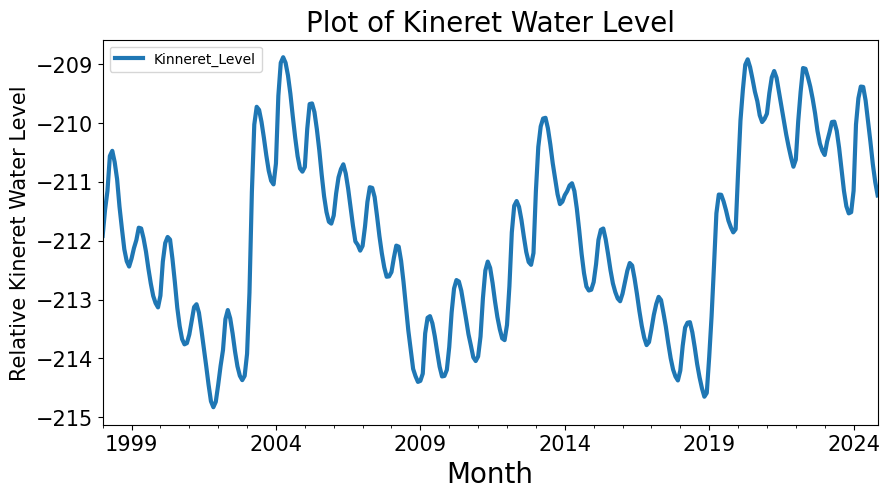

In [31]:
#Plot kinert water line trends
monthly_data_Kineret_plot = monthly_data_Kineret[['Kinneret_Level']]
monthly_data_Kineret_plot.plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.title("Plot of Kineret Water Level",fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Relative Kineret Water Level',fontsize=15);

Text(0, 0.5, 'kinertrt water line - Without\xa0Seasonality')

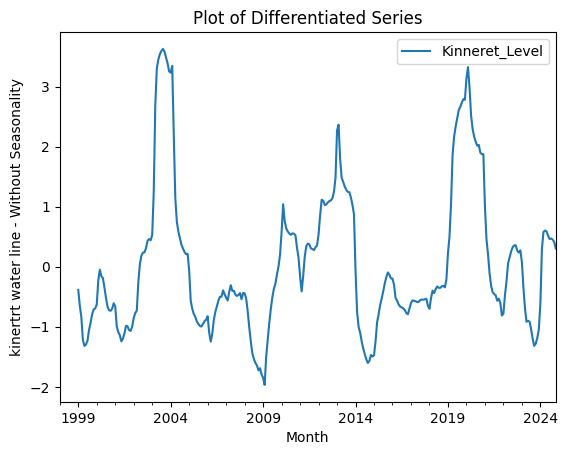

In [33]:
data_without_seasonality = monthly_data_Kineret.diff(periods=12)

data_without_seasonality.plot()
plt.title("Plot of Differentiated Series")
plt.xlabel("Month")
plt.ylabel("kinert water line - Without Seasonality")

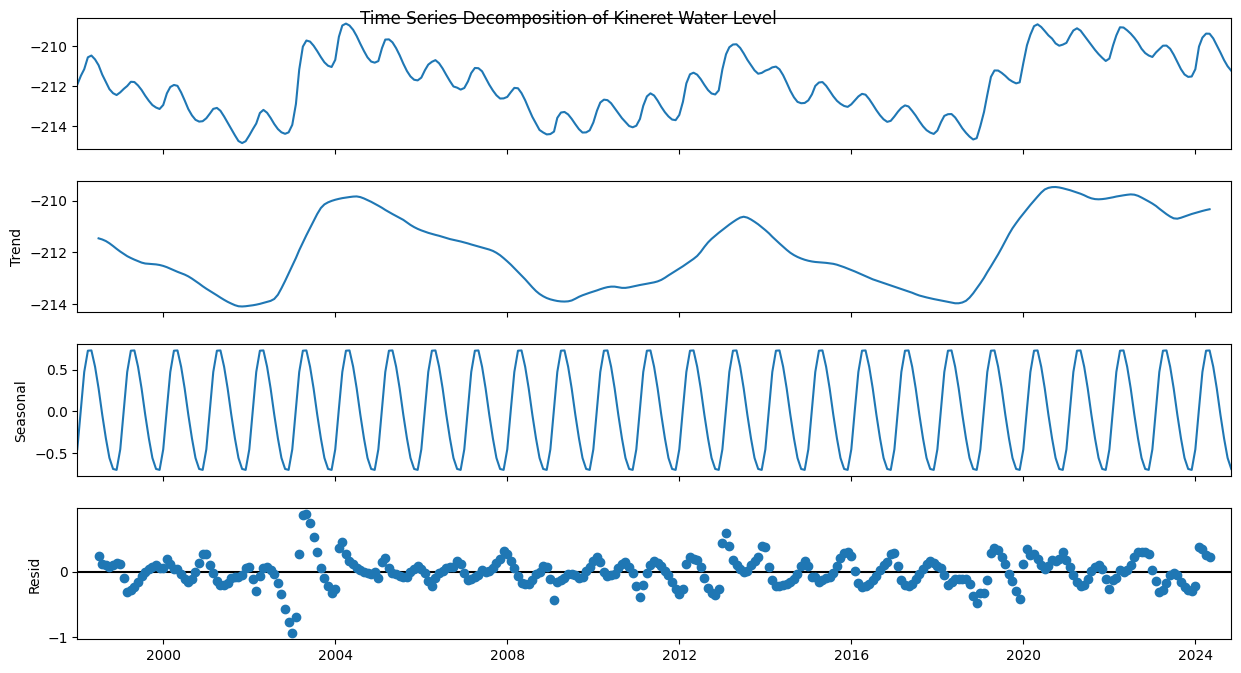

In [28]:
decomposition = seasonal_decompose(monthly_data_Kineret, model='additive', period=12)

fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.suptitle('Time Series Decomposition of Kineret Water Level')
plt.show()